# Proyecto 4: Faces in The Wild

**Integrantes**:
- Lucas Carranza
- David Herencia
- Kalos Lazo
- Lenin Chavez

# **Siamese neural network with facenet for feature extraction**

---
## **1. Libraries**

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

import torchvision
from torchvision import transforms, datasets

In [54]:
# Para mac silicon chip
device = torch.device('mps')
print(f"using device: {device}")

using device: mps


---
## **2. Dataset**

label
0    1100
1    1100
Name: count, dtype: int64


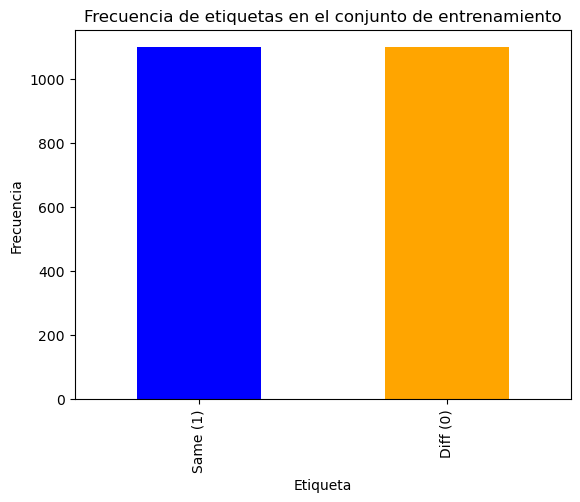

,image1,image2,label
0,1485,4047,0
1,5335,6055,1
2,10796,3696,1
3,11991,6672,1
4,7003,2539,1


In [58]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Split the 'image1_image2' column into two columns
train_df[['image1', 'image2']] = train_df['image1_image2'].str.split('_', expand=True)
test_df[['image1', 'image2']] = test_df['image1_image2'].str.split('_', expand=True)

# Drop the original 'image1_image2' column
train_df.drop(columns=['image1_image2'], inplace=True)
test_df.drop(columns=['image1_image2'], inplace=True)

# Reorder cols
train_df = train_df[['image1', 'image2', 'label']]

# Convert label image to number
# diff = 0
# same = 1
#train_df['label'] = pd.factorize(train_df['label'])[0]

#train_df.head()

train_df['label'] = train_df['label'].apply(lambda x: 0 if x == 'diff' else 1)

# Imprimir la cantidad de ceros y unos
label_counts = train_df['label'].value_counts()
print(label_counts)

# Generar un gráfico de barras
label_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Frecuencia de etiquetas en el conjunto de entrenamiento')
plt.xlabel('Etiqueta')
plt.ylabel('Frecuencia')
plt.xticks(ticks=[0, 1], labels=['Same (1)', 'Diff (0)'])
plt.show()

train_df.head()

A continuación se define funciones generales encapsuladas en clases de ser necesario para mejorar la eficiencia del desarrollo de nuestro modelo, por ejemplo `ImageHandler` es una clase que alberga clases para poder interactuar con las imagenes de forma sencilla.

In [60]:
class ImageHandler:
    def __init__(self, image_path = "cropped_faces_2"):
        self.image_path = image_path

    def load_img(self, img_id):
        path = f"{self.image_path}/{img_id}.png"
        return Image.open(path)

    def plot_imgs(self, imgs, size = 3):
        img_number = imgs.shape[0]
        rows = cols = math.ceil(np.sqrt(img_number))
        fig = plt.figure(figsize=(rows*size, cols*size))
        for i in range(img_number):
            fig.add_subplot(rows, cols, i+1)
            plt.imshow(imgs[i])
            plt.axis('off')
        plt.show()

    def visualize_samples(self, loader, num_samples = 5, size = 3):
        rows = cols = math.ceil(np.sqrt(num_samples))
        fig = plt.figure(figsize = (rows*size, cols*size))
        for images1, images2, labels in loader:
            for i in range(num_samples):
                plt.subplot(rows, cols, i+1)
                image = images1[i].permute(1, 2, 0).cpu().numpy()  # Change (C, H, W) to (H, W, C) and convert to numpy array
                plt.imshow(image)
                plt.axis('off')
            break
        plt.show()

In [62]:
print('> Train data before image splitting and label encoder');
print(train_df.head())

print('\n> Test data before image splitting and label encoder');
print(test_df.head())

> Train data before image splitting and label encoder
  image1 image2  label
0   1485   4047      0
1   5335   6055      1
2  10796   3696      1
3  11991   6672      1
4   7003   2539      1

> Test data before image splitting and label encoder
  image1 image2
0   6874   1599
1  11365  12931
2  10132   4581
3   4706  12001
4   3350   8318


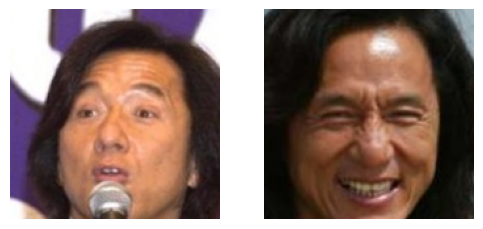

(160, 160, 3)

In [64]:
ih = ImageHandler()

im1 = ih.load_img(train_df['image1'][1347])
im2 = ih.load_img(train_df['image2'][1347])

ih.plot_imgs(np.array([im1, im2]))
np.array(im1).shape

---
## **3. Custom dataset**

### Data Loader for Siamese CNN

Debido a que la Red Neuronal Convolucional requiere de 2 entradas de imagenes para validar si corresponden a la misma persona o no, requerimos de un Dataset personalizado, donde la entrada consista en 2 imagenes y un label. Es por esto que creamos la clase `TwoImageDataset` a partir de la clase `Dataset` de pytorch, la cual puede obtener todos los pares de imágenes y cargarlos de dos en dos junto con el label que nos indican si son la misma persona o no.

In [73]:
class TwoImageDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        self.df = df
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img1_id = self.df.iloc[idx, 0]
        img2_id = self.df.iloc[idx, 1]

        img1 = ih.load_img(img1_id).convert('RGB')
        img2 = ih.load_img(img2_id).convert('RGB')
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if self.is_test:
            return img1, img2
            
        label = self.df.iloc[idx, 2]
        return img1, img2, torch.tensor(label, dtype=torch.float32)

### Data augmentation

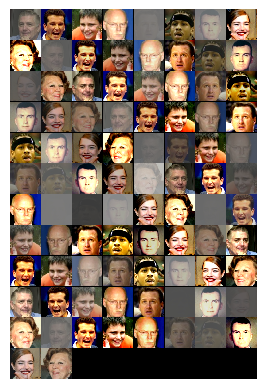

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.utils import make_grid
from torchvision import transforms

batch_size = 64

# Definir las transformaciones de augmentación de datos
data_augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(kernel_size=3,sigma=(0.1, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=1, saturation=0.2),
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])


# Define validation/test transformations
val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Train-Test split
train_subset_df, val_subset_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=12)


# Initializing custom datasets with transformations
train_dataset = TwoImageDataset(train_subset_df, transform=data_augmentation_transforms)
val_dataset = TwoImageDataset(val_subset_df, transform=val_test_transforms)
test_dataset = TwoImageDataset(test_df, transform=val_test_transforms, is_test=True)

# Initialize the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)



def show_dataset(dataset, n=10):

    imgs = torch.stack([dataset[i][0] for _ in range(n)
                       for i in range(9)])
    grid = make_grid(imgs).numpy()
    plt.imshow(np.transpose(grid, (1, 2, 0)), interpolation='nearest')
    plt.axis('off')

show_dataset(train_dataset)



---
## **4. Implementation**

In [22]:
from facenet_pytorch import InceptionResnetV1

/opt/anaconda3/envs/MachineL/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [132]:
# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()
#print(nn.Sequential(*list(resnet.children())[:]))


In [88]:
from facenet_pytorch import InceptionResnetV1

class SNN(nn.Module):
    def __init__(self):
        super(SNN, self).__init__()
        self.resnet = InceptionResnetV1(pretrained='vggface2').eval()  # Usar el modelo preentrenado
        self.conv1 = nn.Sequential(*list(resnet.children())[:])
        
        # Congelar todas las capas del modelo Facenet
        for param in self.resnet.parameters():
            param.requires_grad = False
        for param in resnet.block8.parameters():
            param.requires_grad = True
            
        # Capas completamente conectadas después de la extracción de características
        # Salida de 512 por imagen
        self.fc = nn.Sequential(
            nn.Linear(512 * 2, 1024),  # Ajustar el tamaño de entrada
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        embeddings = self.resnet(x)
        return embeddings

    def forward(self, img1, img2):
        out1 = self.forward_once(img1)
        out2 = self.forward_once(img2)
        concat = torch.cat((out1, out2), 1)
        output = self.fc(concat)
        return output

    def train_cnn(self, train_loader, val_loader, loss_fn, optimizer, scheduler=None, num_epochs=5, patience=5):
        total_step = len(train_loader)
        list_loss = []
        best_loss = float('inf')
        epochs_no_improve = 0
        
        for epoch in range(num_epochs):
            self.train()
            epoch_loss = 0.0
            
            for i, (images1, images2, labels) in enumerate(train_loader):
                images1 = images1.to(device)
                images2 = images2.to(device)
                labels = labels.to(device).unsqueeze(1) 
                
                output = self(images1, images2)
                loss = loss_fn(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                list_loss.append(loss.item())

                if (i + 1) % 100 == 0:
                    print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}')
                
            avg_train_loss = epoch_loss / total_step
            avg_val_loss = self.evaluate(val_loader, loss_fn)
            
            scheduler.step()
            print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                epochs_no_improve = 0

            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print('Early stopping triggered.')
                    break
        print('Finished Training Trainset')

        return list_loss
    def evaluate(self, val_loader, loss_fn):
        y_pred = []
        running_loss = 0.0
        self.eval()
        with torch.no_grad():
            for image1, image2, labels in val_loader:
                image1, image2, labels = image1.to(device), image2.to(device), labels.to(device).unsqueeze(1)
                output = self(image1, image2)
                loss = loss_fn(output, labels)
                running_loss += loss.item()
                output = output.cpu()
                pred = torch.round(output * 1000) / 1000 
                y_pred.append(float(pred.item()))
        avg_val_loss = running_loss / len(val_loader)
        return avg_val_loss
    def predict(self, dataloader, with_labels=False):
        y_pred = []
        self.eval()
        with torch.no_grad():
            if not with_labels:
                for image1, image2 in dataloader:
                    image1, image2 = image1.to(device), image2.to(device)
                    output = self(image1, image2)
                    output = output.cpu()
                    pred = torch.round(output)
                    y_pred.append(int(pred.item()))
            else:
                for image1, image2, _ in dataloader:
                    image1, image2 = image1.to(device), image2.to(device)
                    output = self(image1, image2)
                    output = output.cpu()
                    pred = torch.round(output)
                    y_pred.append(int(pred.item()))
        return y_pred

---
## **5. Training**

In [116]:
torch.mps.empty_cache()
learning_rate = 1e-4
model1 = SNN().to(device)

loss_fn = nn.BCELoss()

optimizer = torch.optim.Adam(model1.parameters(), lr=learning_rate)

scheduler = StepLR(optimizer=optimizer, step_size=20, gamma=0.1)

In [118]:
torch.mps.empty_cache()
epochs = 50

# Entrenamiento del modelo0
list_loss = model1.train_cnn(train_dataloader,val_dataloader, loss_fn, optimizer, scheduler=scheduler, num_epochs=epochs)

Epoch 1, Training Loss: 0.6531, Validation Loss: 0.6877
Epoch 2, Training Loss: 0.4717, Validation Loss: 0.5715
Epoch 3, Training Loss: 0.3620, Validation Loss: 0.3687
Epoch 4, Training Loss: 0.2803, Validation Loss: 0.2725
Epoch 5, Training Loss: 0.2217, Validation Loss: 0.2165
Epoch 6, Training Loss: 0.1968, Validation Loss: 0.1978
Epoch 7, Training Loss: 0.1645, Validation Loss: 0.1874
Epoch 8, Training Loss: 0.1432, Validation Loss: 0.1727
Epoch 9, Training Loss: 0.1407, Validation Loss: 0.1500
Epoch 10, Training Loss: 0.1162, Validation Loss: 0.1722
Epoch 11, Training Loss: 0.1218, Validation Loss: 0.1578
Epoch 12, Training Loss: 0.1221, Validation Loss: 0.1477
Epoch 13, Training Loss: 0.1211, Validation Loss: 0.1521
Epoch 14, Training Loss: 0.1130, Validation Loss: 0.1641
Epoch 15, Training Loss: 0.1053, Validation Loss: 0.1462
Epoch 16, Training Loss: 0.1082, Validation Loss: 0.1708
Epoch 17, Training Loss: 0.1062, Validation Loss: 0.1464
Epoch 18, Training Loss: 0.0814, Validat

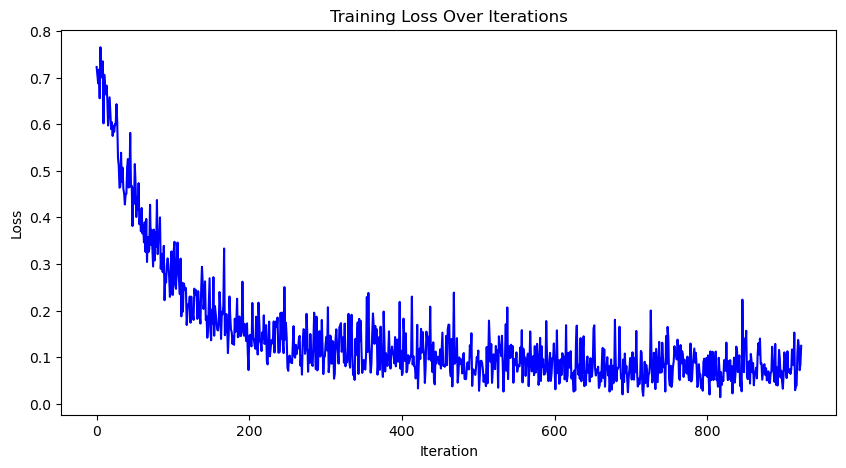

In [120]:
# Plot the loss function
plt.figure(figsize=(10, 5))
plt.plot(list_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')

plt.ylabel('Loss')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       220
           1       0.97      0.98      0.98       220

    accuracy                           0.97       440
   macro avg       0.98      0.97      0.97       440
weighted avg       0.98      0.97      0.97       440



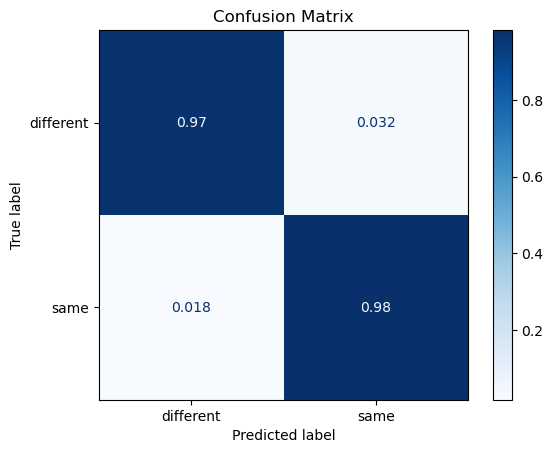

In [124]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

val_pred = model1.predict(val_dataloader, with_labels=True)
cm = confusion_matrix(val_subset_df['label'], val_pred, normalize='true')

# Generate the classification report
report = classification_report(val_subset_df['label'], val_pred)
print("Classification Report:")
print(report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['different', 'same'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

---
## **6. Submission**

In [125]:
test_values = model1.predict(test_dataloader)
print(np.unique(test_values))

[0 1]


In [127]:
test_df_p4 = pd.read_csv("test.csv")  # Asegúrate de que tienes un archivo test.csv cargado

# Crear el DataFrame para la sumisión
submission_df = pd.DataFrame({
    'image1_image2': test_df_p4['image1_image2'],
    'label': ['same' if pred == 1 else 'diff' for pred in test_values]
})

# Guardar el DataFrame en un archivo CSV
submission_df.to_csv('submission_p4.csv', index=False)

print("Submission saved to submission_p4.csv")

Submission saved to submission_p4.csv


In [128]:
# Guardar pesos del Mejor modelo
#torch.save(model1.state_dict(), 'snn_model.pth') -> pesa más de 200mb por eso no se puede guardar en github =c